In [1]:
import requests
import geopandas as gpd
from download import download
import osmnx as ox
import momepy
import libpysal
import numpy as np
import warnings
import pandas as pd
import tobler
import pandana

import utils.momepy
import utils.tobler

In [2]:
import warnings

warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

In [3]:
fua = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg")
fua_4326 = fua.to_crs(4326)
fua_4326.geometry = fua_4326.buffer(0)  # fix geometry topology
hk_fua = fua_4326[fua_4326.eFUA_name == 'Hong Kong'].geometry.iloc[0]

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


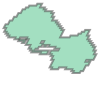

In [4]:
hk_fua

### Street network

In [5]:
%%time
type_filter = '["highway"~"living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link"]'

streets_graph = ox.graph_from_polygon(hk_fua, network_type='all_private', custom_filter=type_filter, retain_all=True)
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.highway = gdf.highway.astype(str)
path = f'../../urbangrammar_samba/sp_sig_concept/hong_kong/roads_osm.pq'
gdf[['highway', 'geometry']].to_parquet(path)

CPU times: user 44.7 s, sys: 456 ms, total: 45.2 s
Wall time: 1min


### Buildings

In [6]:
%%time
footprints = ox.geometries.geometries_from_polygon(hk_fua, tags={'building':True})
footprints_proj = ox.projection.project_gdf(footprints)
path = f'../../urbangrammar_samba/sp_sig_concept/hong_kong/footprints_osm.pq'
footprints_proj[['building', 'building:levels', 'geometry']].to_parquet(path)

<timed exec>:4: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


CPU times: user 1min 21s, sys: 930 ms, total: 1min 22s
Wall time: 1min 41s


### Barriers

In [7]:
%%time
tags = {'natural': ['water', 'coastline', 'spring']}
gdf = ox.geometries_from_polygon(hk_fua, tags)
path = f'../../urbangrammar_samba/sp_sig_concept/hong_kong/water_osm.pq'
gdf[['natural', 'geometry']].to_parquet(path)

CPU times: user 903 ms, sys: 4.28 ms, total: 908 ms
Wall time: 4.61 s


<timed exec>:4: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


In [9]:
tags = {'railway': True}
gdf = ox.geometries_from_polygon(hk_fua, tags)
gdf = gdf[gdf.geom_type == 'LineString']
gdf = gdf[gdf.tunnel != 'yes']
path = f'../../urbangrammar_samba/sp_sig_concept/hong_kong/railway_osm.pq'
gdf[['railway', 'geometry']].to_parquet(path)

<ipython-input-9-f76e569f604d>:6: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf[['railway', 'geometry']].to_parquet(path)


## Data preprocessing

In [13]:
buildings = gpd.read_parquet('../../urbangrammar_samba/sp_sig_concept/hong_kong/footprints_osm.pq')

In [15]:
buildings.geom_type.value_counts()

Polygon         43719
Point             114
MultiPolygon       18
LineString          7
dtype: int64

In [ ]:
buildings = buildings.explode()
buildings = buildings[buildings.geom_type == "Polygon"]

In [ ]:
ox.geometries_from_polygon(hk_fua, tags={'building':True})